In [ ]:
# %%

import soundfile as sf
import matplotlib.pyplot as plt
from tqdm.gui import tqdm as tqdm_gui
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import librosa
from data.dataset import AudioDataset
from data.config import *
import torchsummary as summary

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_channels, base_channels):
        super(ResUNet, self).__init__()
    
        # Encoder
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels, base_channels,
                      kernel_size=3, stride=1, padding=1),
        )

        self.shortcut1 = nn.Conv2d(
            in_channels, base_channels, kernel_size=1, padding=0)

        self.encoder_block2 = ResidualBlock(
            base_channels, base_channels * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            base_channels * 2, base_channels * 4, stride=2)

        # Bridge (bottleneck)
        self.bridge = ResidualBlock(
            base_channels * 4, base_channels * 8, stride=2)

        # Decoder
        self.decoder_block1 = DecoderBlock(
            base_channels * 8, base_channels * 4)
        self.decoder_block2 = DecoderBlock(
            base_channels * 4, base_channels * 2)
        self.decoder_block3 = DecoderBlock(
            base_channels * 2, base_channels)

        # Combined output layer
        self.output = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=1, padding=0),
        )

    def forward(self, x):

        x = x.unsqueeze(1)
        # Encoder
        encoder1 = self.encoder_block1(x) + self.shortcut1(x)
        encoder2 = self.encoder_block2(encoder1)
        encoder3 = self.encoder_block3(encoder2)

        # Bridge
        bridge = self.bridge(encoder3)

        # Decoder
        decoder1 = self.decoder_block1(bridge, encoder3)
        decoder2 = self.decoder_block2(decoder1, encoder2)
        decoder3 = self.decoder_block3(decoder2, encoder1)

        # Combined output layer
        output = self.output(decoder3)

        mag_mask = torch.sigmoid(output[:, 0, :, :])
        real_mask = torch.tanh(output[:, 1, :, :])
        imag_mask = torch.tanh(output[:, 2, :, :])

        output_masks_dict = {
            'mag_mask': mag_mask,
            'real_mask': real_mask,
            'imag_mask': imag_mask
        }

        return output_masks_dict

# Spectrogram reconstruction class

In [ ]:
# %%

# class SpectrogramReconstructor:
#     def __init__(self):
#         pass

#     def reconstruct(self, mag_mask, real_mask, imag_mask, mixture_mag, mixture_phase):
#         # Apply masks
#         estimated_mag = mag_mask * mixture_mag
#         cos_phase_mask = torch.cos(real_mask)
#         sin_phase_mask = torch.sin(imag_mask)

#         # Reconstruct the complex spectrogram
#         Y_real = estimated_mag * \
#             (cos_phase_mask * torch.cos(mixture_phase) -
#              sin_phase_mask * torch.sin(mixture_phase))
#         Y_imag = estimated_mag * \
#             (cos_phase_mask * torch.sin(mixture_phase) +
#              sin_phase_mask * torch.cos(mixture_phase))
#         Y_complex = torch.complex(Y_real, Y_imag)

#         return Y_complex

class SpectrogramReconstructor:
    def __init__(self):
        pass

    def magphase(self, real, imag):
        mag = (real ** 2 + imag ** 2) ** 0.5
        cos = real / torch.clamp(mag, 1e-10, np.inf)
        sin = imag / torch.clamp(mag, 1e-10, np.inf)
        return mag, cos, sin

    # def reconstruct(self, mag_mask, real_mask, imag_mask, mixture_mag, mixture_phase):
    #     # Apply masks
    #     estimated_mag = mag_mask * mixture_mag
    #     _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)

    #     # Reconstruct the complex spectrogram
    #     Y_real = estimated_mag * \
    #         (mask_cos * torch.cos(mixture_phase) -
    #          mask_sin * torch.sin(mixture_phase))
    #     Y_imag = estimated_mag * \
    #         (mask_cos * torch.sin(mixture_phase) +
    #          mask_sin * torch.cos(mixture_phase))
    #     Y_complex = torch.complex(Y_real, Y_imag)

    #     return Y_complex

    def reconstruct(self, mag_mask, real_mask, imag_mask, mix_stft):

        # Apply masks
        mix_mag, mix_cos, mix_sin = self.magphase(mix_stft.real, mix_stft.imag)
        _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)
        estimated_mag = mag_mask * mix_mag

        # Reconstruct the complex spectrogram
        Y_real = estimated_mag * (mask_cos * mix_cos - mask_sin * mix_sin)
        Y_imag = estimated_mag * (mask_cos * mix_sin + mask_sin * mix_cos)
        Y_complex = torch.complex(Y_real, Y_imag)

        return Y_complex


# ISTFT conversion function


def istft(y_complex, n_fft, hop_length):

    y = torch.istft(
        y_complex, n_fft, hop_length, window=torch.hann_window(256, device='cuda'), length=31248)

    return y

# Custom dataset class remains the same
# (code provided in the previous response)

In [ ]:
# %%

# Training loop
model = ResUNet(1, 32).to('cuda')
criterion = nn.L1Loss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
reconstructor = SpectrogramReconstructor()

dataset = AudioDataset()
train_data, test_data = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_data, val_data = torch.utils.data.random_split(train_data, [int(
    0.8 * len(train_data)), len(train_data) - int(0.8 * len(train_data))])

train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = DataLoader(val_data, batch_size=20, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

In [ ]:
# %%

num_epochs = 10
n_fft = 256
hop_length = 64
best_val_loss = np.inf  # Initialize with infinity
train_loss = []
val_losss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training Loss: {running_loss:.4f}",
                     colour='green')
    for i, batch in enumerate(train_bar):
        mix_stft = batch['mixture_stft'].to('cuda')
        target_waveform = batch['percussion_audio'].to('cuda')

        optimizer.zero_grad()

        output_masks_dict = model(torch.abs(mix_stft))
        mag_mask = output_masks_dict['mag_mask']
        real_mask = output_masks_dict['real_mask']
        imag_mask = output_masks_dict['imag_mask']

        # Reconstruct the complex spectrogram
        Y_complex = reconstructor.reconstruct(
            mag_mask, real_mask, imag_mask, mix_stft)

        # Convert to time domain
        Y_waveform = istft(Y_complex, n_fft, hop_length).to('cuda')

        # Calculate loss
        loss = criterion(Y_waveform, target_waveform)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        running_loss += loss.item()
        train_bar.set_description(
            f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/(i+1):.4f}')

    running_loss /= len(train_loader)
    train_loss.append(running_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}",
                   colour='red')

    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            mix_stft = batch['mixture_stft'].to('cuda')
            target_waveform = batch['percussion_audio'].to('cuda')

            output_masks_dict = model(torch.abs(mix_stft))
            mag_mask = output_masks_dict['mag_mask']
            real_mask = output_masks_dict['real_mask']
            imag_mask = output_masks_dict['imag_mask']

            # Reconstruct the complex spectrogram
            Y_complex = reconstructor.reconstruct(
                mag_mask, real_mask, imag_mask, mix_stft)

            # Convert to time domain
            Y_waveform = istft(Y_complex, n_fft, hop_length).to('cuda')

            # Calculate loss
            loss = criterion(Y_waveform, target_waveform)
            val_loss += loss.item()
            val_bar.set_description(
                f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/(i+1):.4f}')

        val_loss /= len(val_loader)
        val_losss.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

Epoch 10/10, Validation Loss: 0.0423: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


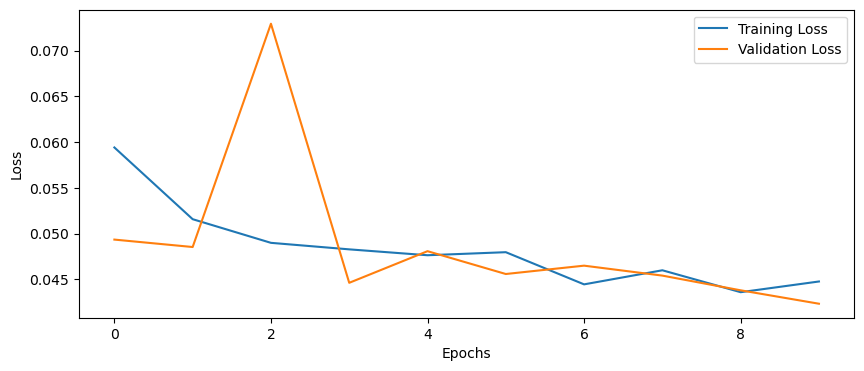

In [ ]:
# %%

# plot the loss

plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_losss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# %%

# Testing
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
progress_bar = tqdm(test_loader, desc=f'Test Loss: {
                    test_loss:.4f}', colour='blue')

with torch.no_grad():
    for i, batch in enumerate(progress_bar):
        mix_stft = batch['mixture_stft'].to('cuda')
        target_waveform = batch['percussion_audio'].to('cuda')

        output_masks_dict = model(torch.abs(mix_stft))
        mag_mask = output_masks_dict['mag_mask']
        real_mask = output_masks_dict['real_mask']
        imag_mask = output_masks_dict['imag_mask']

        # Reconstruct the complex spectrogram
        Y_complex = reconstructor.reconstruct(
            mag_mask, real_mask, imag_mask, mix_stft)

        # Convert to time domain
        Y_waveform = istft(Y_complex, n_fft, hop_length).to('cuda')

        # Calculate loss
        loss = criterion(Y_waveform, target_waveform)
        test_loss += loss.item()
        progress_bar.set_description(
            f'Test Loss: {test_loss/(i+1):.4f}')

test_loss /= len(test_loader)
print(f'Final Test Loss: {test_loss:.4f}')

<ipython-input-6-4f25d05cb8a4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Test Loss: 0.0357: 100%|██████████| 10/10

Final Test Loss: 0.0357


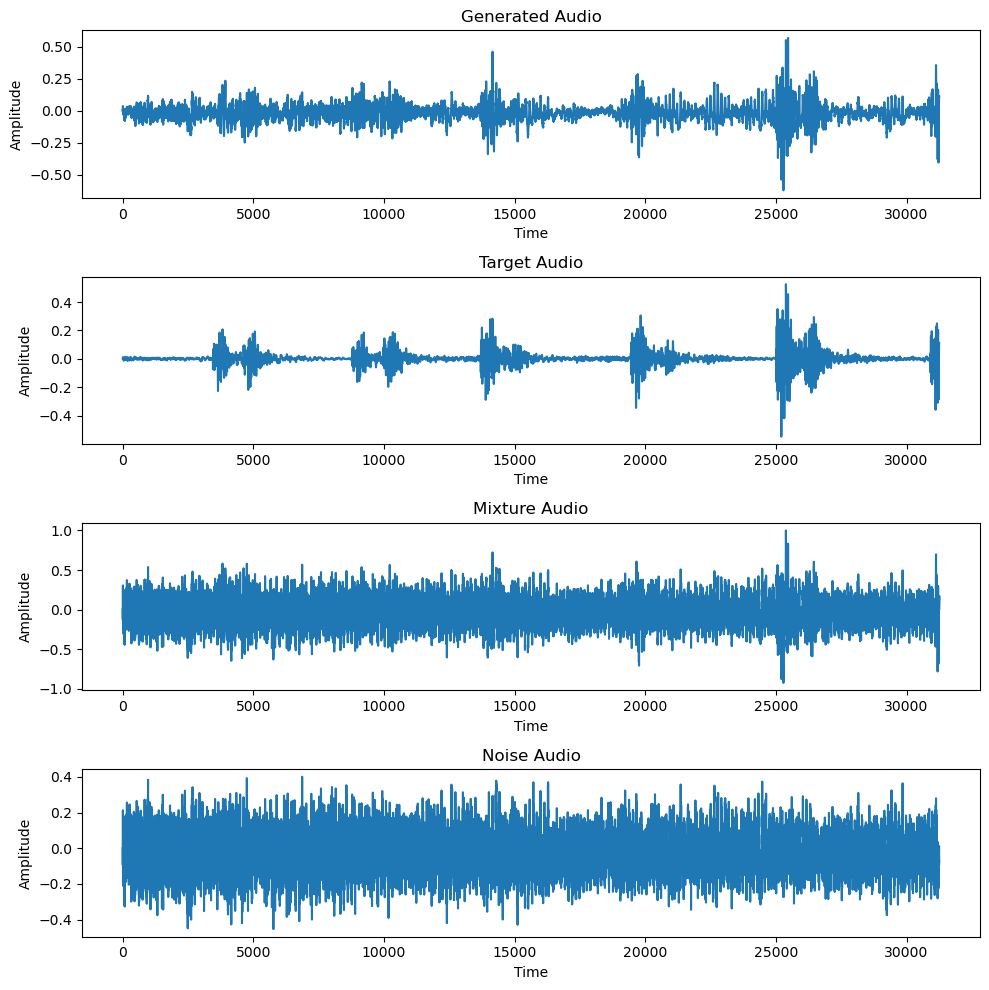

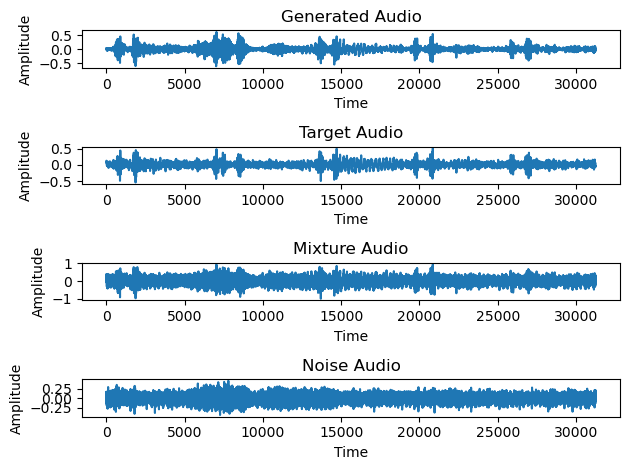

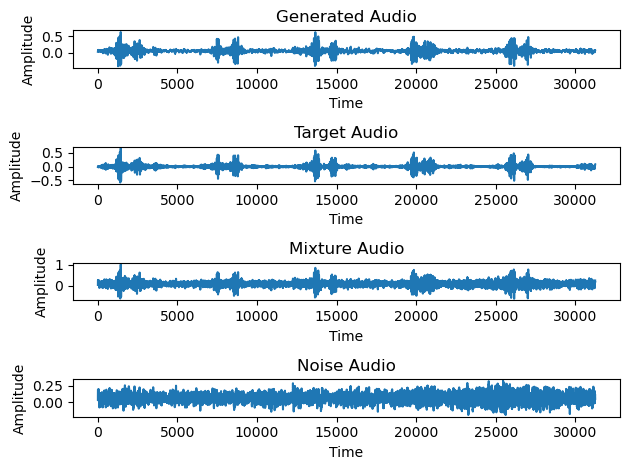

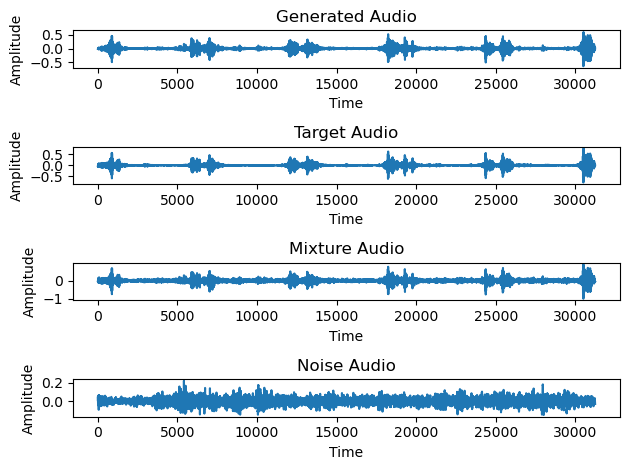

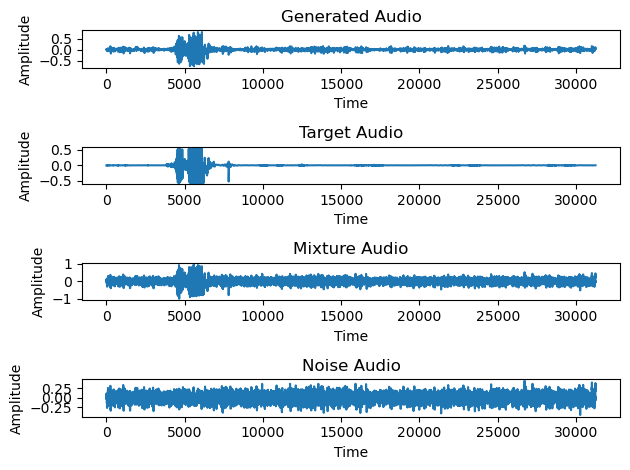

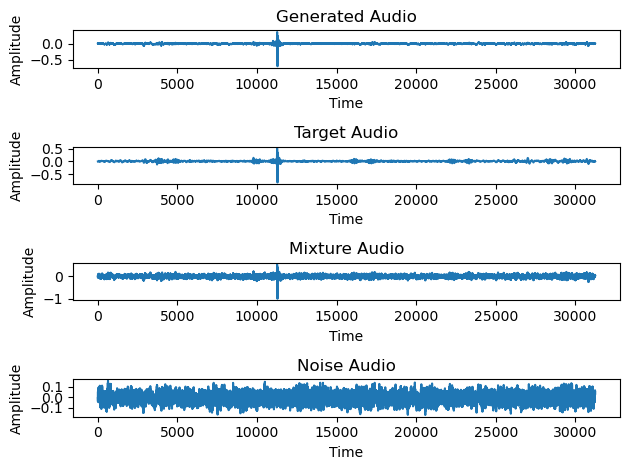

In [ ]:
# %%

# show the audio

Y_waveform_np = Y_waveform.squeeze().detach().cpu().numpy()
mixtures = batch['mixture_audio']
noise = batch['noise_audio']

plt.figure(figsize=(10, 10))
for idx in range(Y_waveform_np.shape[0]):
    plt.subplot(4, 1, 1)
    plt.plot(Y_waveform_np[idx])
    plt.title('Generated Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 2)
    plt.plot(target_waveform[idx].cpu().numpy())
    plt.title('Target Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 3)
    plt.plot(mixtures[idx].cpu().numpy())
    plt.title('Mixture Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.subplot(4, 1, 4)
    plt.plot(noise[idx].cpu().numpy())
    # plt.title('Noise Audio with class: ' + str(batch['noise_class']))
    plt.title('Noise Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# %%

import soundfile as sf
import matplotlib.pyplot as plt
from tqdm.gui import tqdm as tqdm_gui
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import librosa
from data.dataset import AudioDataset
from data.config import *
import torchsummary as summary

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_channels, base_channels):
        super(ResUNet, self).__init__()
    
        # Encoder
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_channels, base_channels,
                      kernel_size=3, stride=1, padding=1),
        )

        self.shortcut1 = nn.Conv2d(
            in_channels, base_channels, kernel_size=1, padding=0)

        self.encoder_block2 = ResidualBlock(
            base_channels, base_channels * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            base_channels * 2, base_channels * 4, stride=2)

        # Bridge (bottleneck)
        self.bridge = ResidualBlock(
            base_channels * 4, base_channels * 8, stride=2)

        # Decoder
        self.decoder_block1 = DecoderBlock(
            base_channels * 8, base_channels * 4)
        self.decoder_block2 = DecoderBlock(
            base_channels * 4, base_channels * 2)
        self.decoder_block3 = DecoderBlock(
            base_channels * 2, base_channels)

        # Combined output layer
        self.output = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=1, padding=0),
        )

    def forward(self, x):

        x = x.unsqueeze(1)
        # Encoder
        encoder1 = self.encoder_block1(x) + self.shortcut1(x)
        encoder2 = self.encoder_block2(encoder1)
        encoder3 = self.encoder_block3(encoder2)

        # Bridge
        bridge = self.bridge(encoder3)

        # Decoder
        decoder1 = self.decoder_block1(bridge, encoder3)
        decoder2 = self.decoder_block2(decoder1, encoder2)
        decoder3 = self.decoder_block3(decoder2, encoder1)

        # Combined output layer
        output = self.output(decoder3)

        mag_mask = torch.sigmoid(output[:, 0, :, :])
        real_mask = torch.tanh(output[:, 1, :, :])
        imag_mask = torch.tanh(output[:, 2, :, :])

        output_masks_dict = {
            'mag_mask': mag_mask,
            'real_mask': real_mask,
            'imag_mask': imag_mask
        }

        return output_masks_dict

# Spectrogram reconstruction class

In [ ]:
# %%

# class SpectrogramReconstructor:
#     def __init__(self):
#         pass

#     def reconstruct(self, mag_mask, real_mask, imag_mask, mixture_mag, mixture_phase):
#         # Apply masks
#         estimated_mag = mag_mask * mixture_mag
#         cos_phase_mask = torch.cos(real_mask)
#         sin_phase_mask = torch.sin(imag_mask)

#         # Reconstruct the complex spectrogram
#         Y_real = estimated_mag * \
#             (cos_phase_mask * torch.cos(mixture_phase) -
#              sin_phase_mask * torch.sin(mixture_phase))
#         Y_imag = estimated_mag * \
#             (cos_phase_mask * torch.sin(mixture_phase) +
#              sin_phase_mask * torch.cos(mixture_phase))
#         Y_complex = torch.complex(Y_real, Y_imag)

#         return Y_complex

class SpectrogramReconstructor:
    def __init__(self):
        pass

    def magphase(self, real, imag):
        mag = (real ** 2 + imag ** 2) ** 0.5
        cos = real / torch.clamp(mag, 1e-10, np.inf)
        sin = imag / torch.clamp(mag, 1e-10, np.inf)
        return mag, cos, sin

    # def reconstruct(self, mag_mask, real_mask, imag_mask, mixture_mag, mixture_phase):
    #     # Apply masks
    #     estimated_mag = mag_mask * mixture_mag
    #     _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)

    #     # Reconstruct the complex spectrogram
    #     Y_real = estimated_mag * \
    #         (mask_cos * torch.cos(mixture_phase) -
    #          mask_sin * torch.sin(mixture_phase))
    #     Y_imag = estimated_mag * \
    #         (mask_cos * torch.sin(mixture_phase) +
    #          mask_sin * torch.cos(mixture_phase))
    #     Y_complex = torch.complex(Y_real, Y_imag)

    #     return Y_complex

    def reconstruct(self, mag_mask, real_mask, imag_mask, mix_stft):

        # Apply masks
        mix_mag, mix_cos, mix_sin = self.magphase(mix_stft.real, mix_stft.imag)
        _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)
        estimated_mag = mag_mask * mix_mag

        # Reconstruct the complex spectrogram
        Y_real = estimated_mag * (mask_cos * mix_cos - mask_sin * mix_sin)
        Y_imag = estimated_mag * (mask_cos * mix_sin + mask_sin * mix_cos)
        Y_complex = torch.complex(Y_real, Y_imag)

        return Y_complex


# ISTFT conversion function


def istft(y_complex, n_fft, hop_length):

    y = torch.istft(
        y_complex, n_fft, hop_length, window=torch.hann_window(256, device='cuda'), length=31248)

    return y

# Custom dataset class remains the same
# (code provided in the previous response)

In [ ]:
# %%

# Training loop
model = ResUNet(1, 32).to('cuda')
criterion = nn.L1Loss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
reconstructor = SpectrogramReconstructor()

dataset = AudioDataset()
train_data, test_data = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_data, val_data = torch.utils.data.random_split(train_data, [int(
    0.8 * len(train_data)), len(train_data) - int(0.8 * len(train_data))])

train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = DataLoader(val_data, batch_size=20, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

In [ ]:
# %%

num_epochs = 50
n_fft = 256
hop_length = 64
best_val_loss = np.inf  # Initialize with infinity
train_loss = []
val_losss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training Loss: {running_loss:.4f}",
                     colour='green')
    for i, batch in enumerate(train_bar):
        mix_stft = batch['mixture_stft'].to('cuda')
        target_waveform = batch['percussion_audio'].to('cuda')

        optimizer.zero_grad()

        output_masks_dict = model(torch.abs(mix_stft))
        mag_mask = output_masks_dict['mag_mask']
        real_mask = output_masks_dict['real_mask']
        imag_mask = output_masks_dict['imag_mask']

        # Reconstruct the complex spectrogram
        Y_complex = reconstructor.reconstruct(
            mag_mask, real_mask, imag_mask, mix_stft)

        # Convert to time domain
        Y_waveform = istft(Y_complex, n_fft, hop_length).to('cuda')

        # Calculate loss
        loss = criterion(Y_waveform, target_waveform)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        running_loss += loss.item()
        train_bar.set_description(
            f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/(i+1):.4f}')

    running_loss /= len(train_loader)
    train_loss.append(running_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}",
                   colour='red')

    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            mix_stft = batch['mixture_stft'].to('cuda')
            target_waveform = batch['percussion_audio'].to('cuda')

            output_masks_dict = model(torch.abs(mix_stft))
            mag_mask = output_masks_dict['mag_mask']
            real_mask = output_masks_dict['real_mask']
            imag_mask = output_masks_dict['imag_mask']

            # Reconstruct the complex spectrogram
            Y_complex = reconstructor.reconstruct(
                mag_mask, real_mask, imag_mask, mix_stft)

            # Convert to time domain
            Y_waveform = istft(Y_complex, n_fft, hop_length).to('cuda')

            # Calculate loss
            loss = criterion(Y_waveform, target_waveform)
            val_loss += loss.item()
            val_bar.set_description(
                f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/(i+1):.4f}')

        val_loss /= len(val_loader)
        val_losss.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

Epoch 50/50, Validation Loss: 0.0420: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


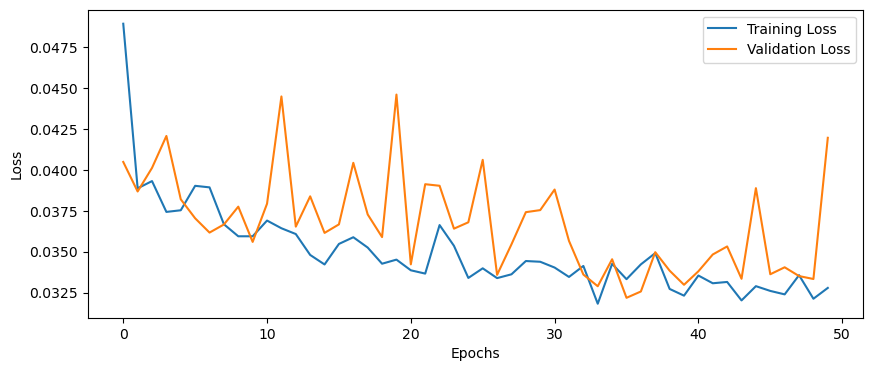

In [ ]:
# %%

# plot the loss

plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_losss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# %%

# Testing
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
progress_bar = tqdm(test_loader, desc=f'Test Loss: {
                    test_loss:.4f}', colour='blue')

with torch.no_grad():
    for i, batch in enumerate(progress_bar):
        mix_stft = batch['mixture_stft'].to('cuda')
        target_waveform = batch['percussion_audio'].to('cuda')

        output_masks_dict = model(torch.abs(mix_stft))
        mag_mask = output_masks_dict['mag_mask']
        real_mask = output_masks_dict['real_mask']
        imag_mask = output_masks_dict['imag_mask']

        # Reconstruct the complex spectrogram
        Y_complex = reconstructor.reconstruct(
            mag_mask, real_mask, imag_mask, mix_stft)

        # Convert to time domain
        Y_waveform = istft(Y_complex, n_fft, hop_length).to('cuda')

        # Calculate loss
        loss = criterion(Y_waveform, target_waveform)
        test_loss += loss.item()
        progress_bar.set_description(
            f'Test Loss: {test_loss/(i+1):.4f}')

test_loss /= len(test_loader)
print(f'Final Test Loss: {test_loss:.4f}')

<ipython-input-7-4f25d05cb8a4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Test Loss: 0.0270: 100%|██████████| 10/10

Final Test Loss: 0.0270


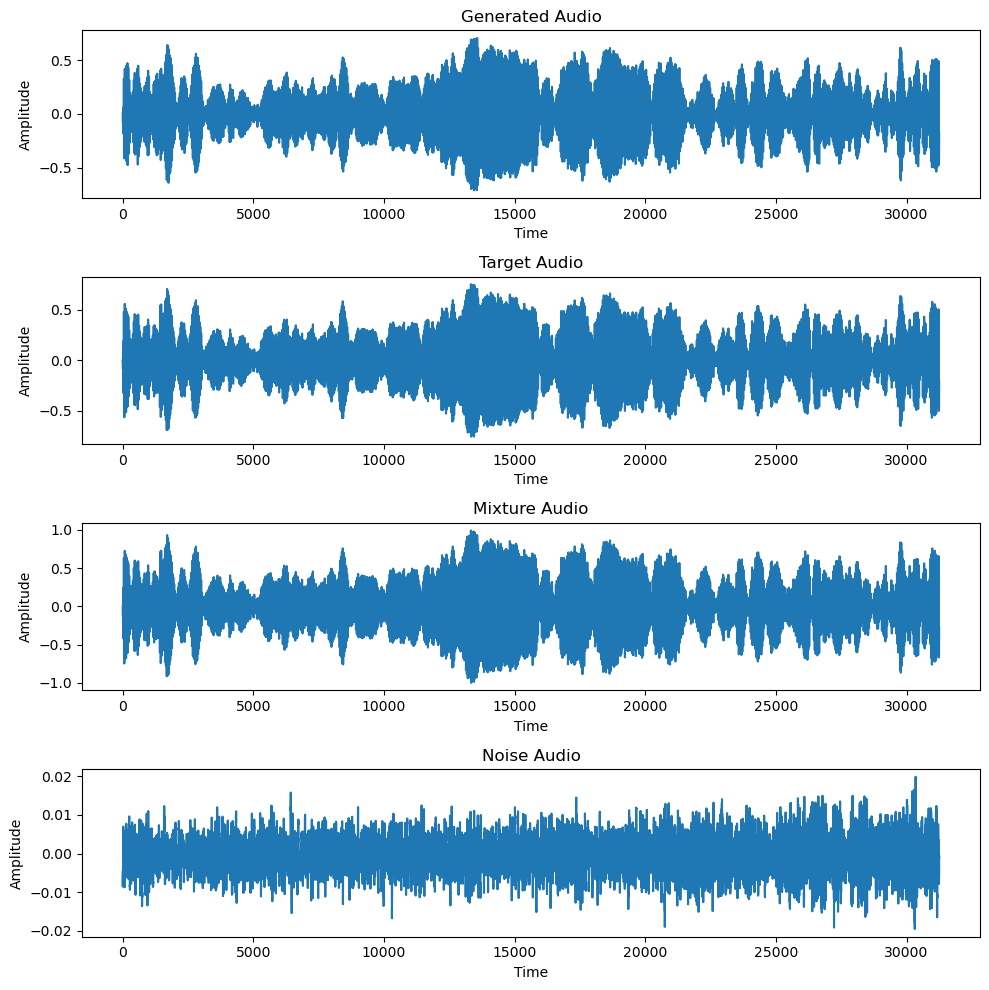

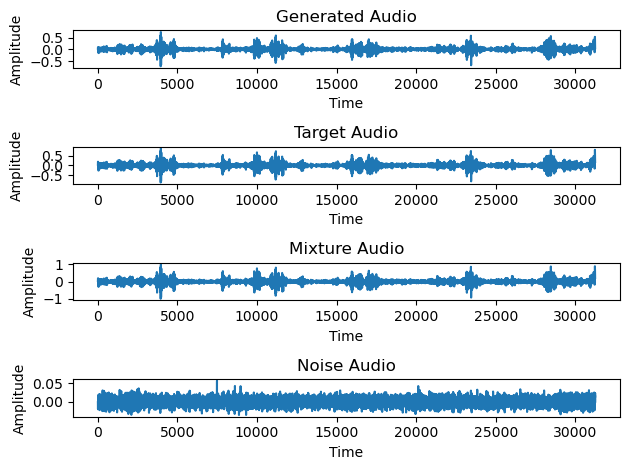

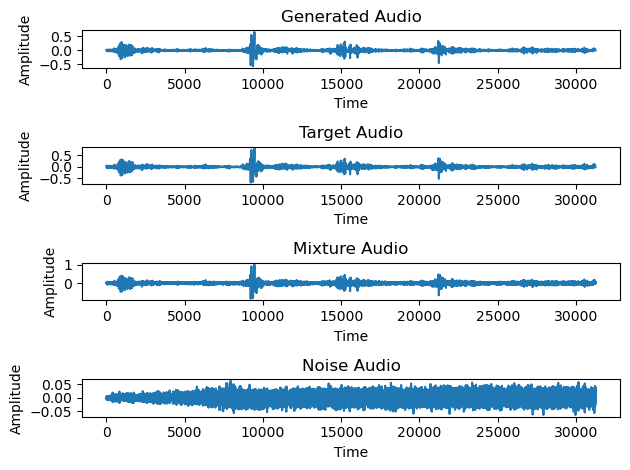

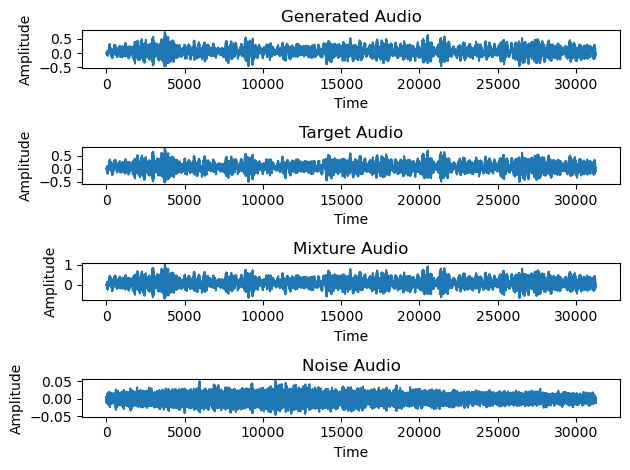

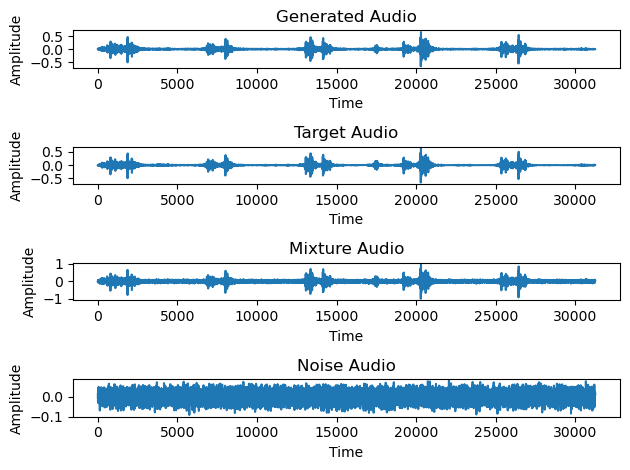

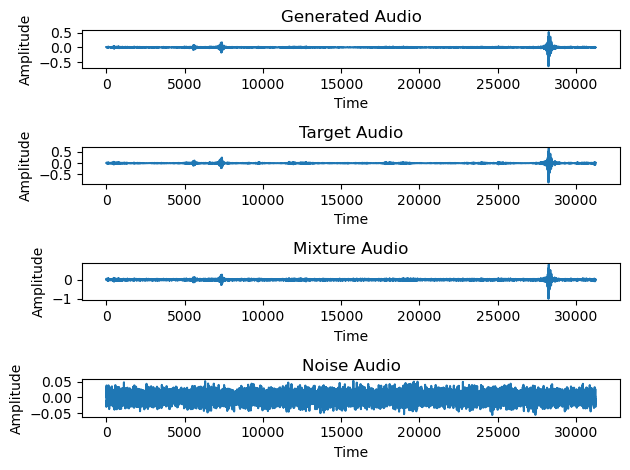

In [ ]:
# %%

# show the audio

Y_waveform_np = Y_waveform.squeeze().detach().cpu().numpy()
mixtures = batch['mixture_audio']
noise = batch['noise_audio']

plt.figure(figsize=(10, 10))
for idx in range(Y_waveform_np.shape[0]):
    plt.subplot(4, 1, 1)
    plt.plot(Y_waveform_np[idx])
    plt.title('Generated Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 2)
    plt.plot(target_waveform[idx].cpu().numpy())
    plt.title('Target Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 3)
    plt.plot(mixtures[idx].cpu().numpy())
    plt.title('Mixture Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.subplot(4, 1, 4)
    plt.plot(noise[idx].cpu().numpy())
    # plt.title('Noise Audio with class: ' + str(batch['noise_class']))
    plt.title('Noise Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()